<a href="https://colab.research.google.com/github/salvador-arenas-castro/FORHAB-Guia-para-el-desarrollo-de-modelos-predictivos-de-habitat-en-sistemas-forestales/blob/main/Copia_de_Invasion_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [ ]:
pip install collections

In [ ]:
pip install networkx

In [ ]:
pip install matplotlib

In [ ]:
pip install random

In [ ]:
import numpy as np
from itertools import combinations
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
def is_singular(matrix):
    determinant = np.linalg.det(matrix)
    return abs(determinant) < 1e-10  # Define a threshold for singularity

# We will study invasion graphs for the Lotka Volterra system below:

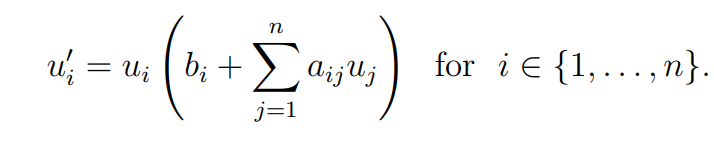

The code below finds the admissible equilibria for Lotka Volterra System. The function receives the matrix A of species to species relations and the vector b of intrinsic growth rates. The output of the function is a dictionary. Any admissible equilibrium in the positive phase space is a value in the dictionary. The associated key for a given equilibrium is the set of species that are coexisting in this equilibrium. So for example if we are working with a three species system, species 0, 1 and 2, and (0,2.4,3.1) is an equilibrium (that is, the first species has zero abundance, second species has 2.4 abundance and third species has 3.1 abundance), then the vector [0,2.4,3.1] is the value of u_S_dict with the key (1,2), meaning that the community is between species 1 and 2, with species 0 excluded.

In [ ]:
def find_u_S(A, b, tol=1e-6): # This finds the admissible equilibria. The dictionary u_S have keys that are subsets of the species (ex: (0,1)),
                                # representing the species that are not null in an equilibrium, and the associate value for this key is the
                                # equilibrium point.
    n = len(b)
    u_S_dict = {}
    A = np.array(A)  # Ensure A is a numpy array

    for r in range(0, n+1):
        for subset in combinations(range(n), r):
            # Create mask for coordinates in S
            mask = np.zeros(n)
            mask[list(subset)] = 1

            # Create system of equations for coordinates in S
            A_S = A[np.ix_(list(subset), list(subset))]
            b_S = -b[list(subset)]
            if not is_singular(A_S):
                u_S = np.linalg.solve(A_S, b_S)  # find an equilibrium of the Lotka Volterra equation considering the mask
                u = np.zeros(n)
                u[list(subset)] = u_S

                # Check if solution satisfies condition of positiveness
                if np.all(u_S > 0):
                    u_S_dict[subset] = u

    return u_S_dict

# Below is the definition of invasion rates. An invasion rate r_i(I) is defined as the eigenvalue of the eigenvector (0,...,1,...,0) (1 in the ith position) of the linearization of the system around an equilibrium associated to the community I. If it is positive, then the outsider species i sources from the community formed by the species in I in the linearized ODE system.

# Let us check an example in a two dimensional system! A = [[-1, 1], [-1, -1]]

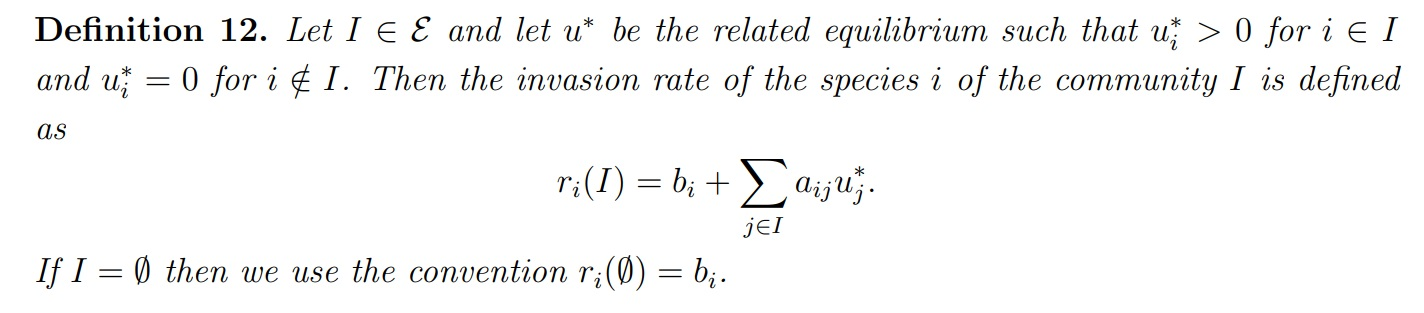

In [ ]:
def calculate_r(i, I, A, b, u_S): # This calculates the invasion rate of species i in ecosystem I with equilibrium u_S
    r = b[i]
    for j in I:
        r += A[i][j] * u_S[j]
    return r

# Construction of the invasion graph G:

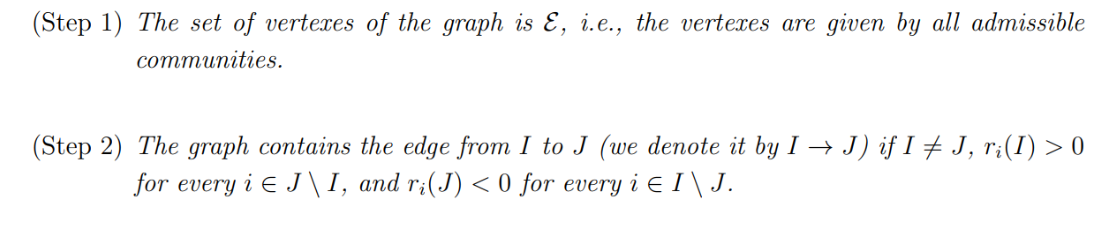

# This algorythm ads an edge from community I to community J if all outsider species in J source from I and all species in I that are not in J don't source (decay) around the equilibrium associated to J.

In [ ]:
def create_invasion_graph(A, b):  # This creates the invasion graph according to the algorythm above
    u_S_dict = find_u_S(A, b)
    G = nx.DiGraph()
    # Group subsets by their length
    grouped_subsets = defaultdict(list)
    for subset in u_S_dict.keys():
        grouped_subsets[len(subset)].append(subset)

    # Distribute nodes horizontally based on their length
    for length, subsets in grouped_subsets.items():
        num_subsets = len(subsets)
        for i, subset in enumerate(subsets):
            x_coordinate = - (len(subsets) // 2) + i
            if len(subsets) % 2 == 0:
                x_coordinate += 0.5
            G.add_node(subset, pos=(2 * x_coordinate, length + abs(x_coordinate) / (1.3 * (length + 1))))
            #G.add_node(subset, pos=(2 * x_coordinate, length))
    p=0
    for node_i, u_i in u_S_dict.items():
        for node_j, u_j in u_S_dict.items():
            if node_i != node_j:
                JminusI = tuple(item for item in node_j if item not in node_i)
                IminusJ = tuple(item for item in node_i if item not in node_j)
                positive_edges = all(calculate_r(i, node_i, A, b, u_i) > 0 for i in JminusI)
                negative_edges = all(calculate_r(i, node_j, A, b, u_j) < 0 for i in IminusJ)
                if positive_edges and negative_edges:
                    G.add_edge(node_i, node_j)

    return G

In [ ]:
def draw_invasion_graph(G):
    # Detect cycles in the graph
    cycles = list(nx.simple_cycles(G))
    pos = nx.get_node_attributes(G, 'pos')  # Get node positions
    labels = {node: str(node) for node in G.nodes()}  # Convert frozenset to string for labels
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=1000, node_color='lightblue', font_size=10, font_weight='bold')
    for cycle in cycles:
        cycle_edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
        nx.draw_networkx_edges(G, pos, edgelist=cycle_edges, edge_color='red', width=3, arrows = True, arrowstyle='->', node_size=1000)
    plt.title("Invasion Graph")
    plt.show()

In [ ]:
def draw_1_species(G):
    # Extract isolated nodes
    isolated_nodes = [(0,), (1,), (2,), (3,), (4,)]

    # Create a subgraph with isolated nodes
    iso = G.subgraph(isolated_nodes)

    # Compute the positions of the nodes in the circular layout
    num_nodes = len(iso)
    angle = 2.0 * 3.141592653589793 / num_nodes
    pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(isolated_nodes)}


    nx.draw(iso, pos=pos, with_labels=True, node_color='skyblue', node_size=500, font_size=12)

    plt.show()

In [ ]:
def check_loops(G):   # Calculates the loops in a graph
    loops = list(nx.simple_cycles(G))
    return loops

In [ ]:
def has_cycle(G):  # Checks faster if a graph has loops, returns true or false
    visited = set()
    stack = set()

    def dfs(node):
        if node in stack:
            return True
        if node in visited:
            return False

        visited.add(node)
        stack.add(node)

        for neighbor in G.neighbors(node):
            if dfs(neighbor):
                return True

        stack.remove(node)
        return False

    for node in G.nodes():
        if dfs(node):
            return True
    return False

In [ ]:
def has_jumps(graph): # Checks if a graph has jumps, that is, a transition that ads or kills more than one species at once
    edges = list(graph.edges())
    saltos = []
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        if abs(len(node1) - len(node2)) > 1:
            saltos.append((node1, node2))
    return saltos

# The loop below searches for cycles in invasion graphs associated to Volterra Lyapunov stable systems. In the case of hyperbolic Volterra Lyapunov systems, any connection in the invasion graph is in the global attractor, and vice versa. Therefore, cycles can indicate looong periodic transient behavior in such systems, which is opposite to the previous ideas that Volterra Lyapunov stable systems were trivial or gradient.


# First we have black box functions to generate Volterra Lyapunov stable matrices, then we make a loop to sort these matrices and check the associated invasion graphs. If we find a loop, we print it.

In [ ]:
def random_negative_diagonal(n):
    # Generate random negative values for the diagonal
    diagonal = -np.random.rand(n)  # generating random values between 0 and 1 and then negating them

    # Create diagonal matrix
    diagonal_matrix = np.diag(diagonal)

    return diagonal_matrix


def generate_pos_diag(n):
    list_d = []
    for i in range(n):
        r = 0
        while r == 0:
            r = random.randint(1,10)
        list_d.append(r)
    return np.diag(list_d)

def calculate_VL_stable(S):
    J = np.random.randint(-10, 10, size=(S.shape[0], S.shape[1])) / 10
    #H = generate_pos_diag(len(S))
    H = np.eye(len(S))
    #H = np.diag([1 for i in range(len(S))])
    result = S + J - J.T
    # Divide by 2
    result /= 2
    VL = np.dot(H, result)
    return VL, H, J

index=  0
A=  [[-0.08587475 -0.55       -0.7         0.45      ]
 [ 0.55       -0.09378007 -0.75       -0.75      ]
 [ 0.7         0.75       -0.14351319 -0.1       ]
 [-0.45        0.75        0.1        -0.03763132]]
H=  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b=  [1. 1. 1. 1.]
saltos:  [((), (0, 1, 3)), ((), (0, 2, 3))]
loops:
[(0,), (1,), (2,), (3,)]
[(0,), (1,), (3,)]
[(0,), (2,), (3,)]


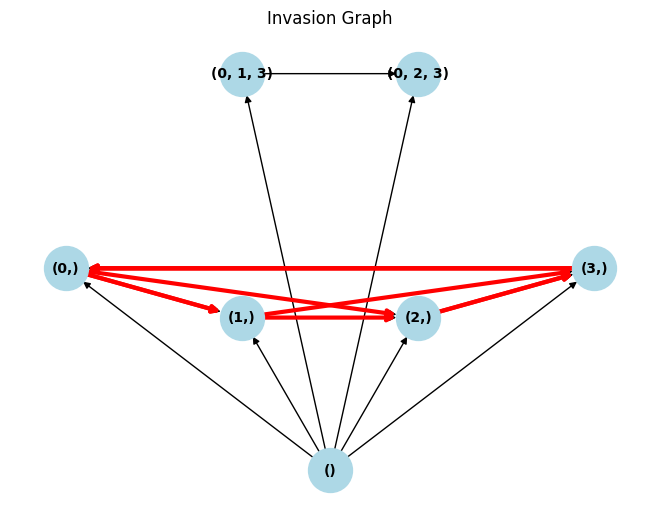

index=  1
A=  [[-0.01233243  0.35       -0.5         0.6       ]
 [-0.35       -0.35648598  0.5        -0.05      ]
 [ 0.5        -0.5        -0.23595425  0.2       ]
 [-0.6         0.05       -0.2        -0.18747441]]
H=  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b=  [1. 1. 1. 1.]
saltos:  [((), (1, 3)), ((), (2, 3)), ((), (0, 1, 2)), ((), (1, 2, 3)), ((2,), (1, 2, 3)), ((3,), (0, 1, 2)), ((3,), (1, 2, 3))]
loops:
[(0,), (2,), (1,)]
[(0,), (2,), (1,), (1, 3)]


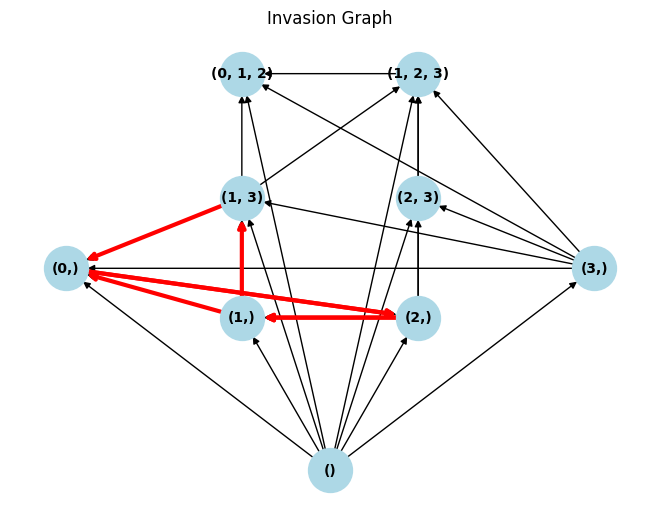

index=  2
A=  [[-0.14144881 -0.2        -0.55        0.7       ]
 [ 0.2        -0.40818889 -0.05       -0.55      ]
 [ 0.55        0.05       -0.36479943 -0.25      ]
 [-0.7         0.55        0.25       -0.2324892 ]]
H=  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b=  [1. 1. 1. 1.]
saltos:  [((), (0, 1)), ((), (1, 2)), ((), (0, 1, 3)), ((), (0, 2, 3)), ((1,), (0, 1, 3)), ((1,), (0, 2, 3))]
loops:
[(0, 1), (1, 2), (3,), (0,)]
[(0,), (2,), (3,)]
[(0,), (2,), (1, 2), (3,)]
[(0,), (1, 2), (3,)]


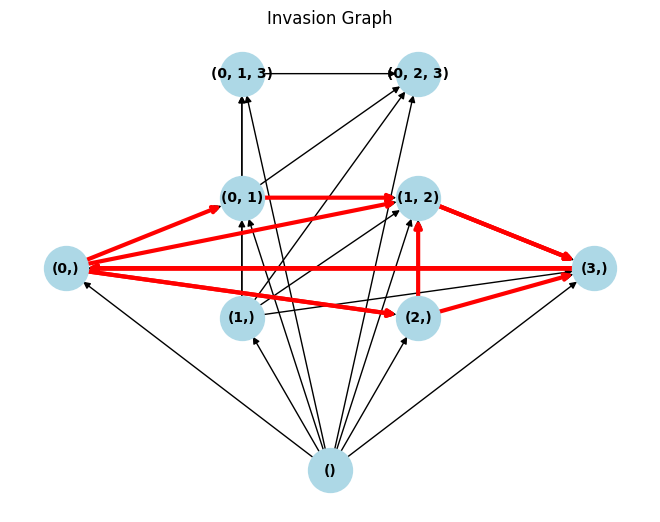

index=  3
A=  [[-0.24894924  0.1         0.5        -0.65      ]
 [-0.1        -0.17427926 -0.6         0.1       ]
 [-0.5         0.6        -0.40020413  0.45      ]
 [ 0.65       -0.1        -0.45       -0.28095443]]
H=  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
b=  [1. 1. 1. 1.]
saltos:  [((), (0, 1)), ((), (1, 3)), ((), (0, 1, 2)), ((), (0, 1, 3)), ((), (0, 2, 3)), ((0,), (0, 1, 3)), ((1,), (0, 1, 2)), ((1,), (0, 1, 3)), ((1,), (0, 2, 3))]
loops:
[(0,), (3,), (2,)]
[(0,), (3,), (1, 3), (2,)]


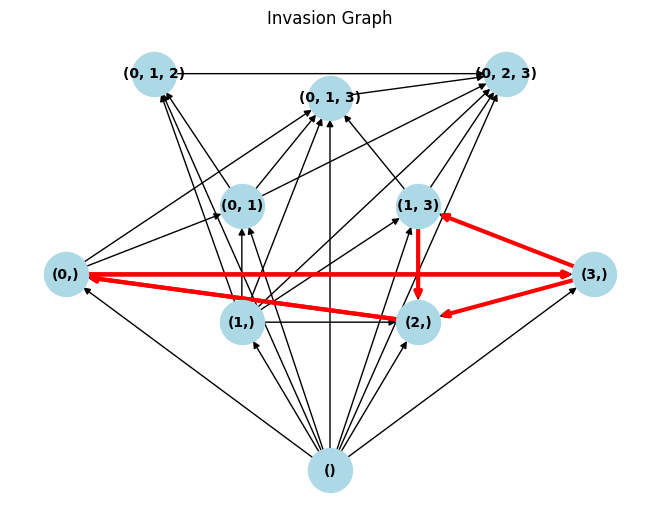

In [ ]:
low_b = 1.0
high_b = 1.0
low_A = -1.0
high_A = 1.0

# Generate and check matrices and vectors
graph_storage = []
A_storage = []
H_storage = []
b_storage = []
index = 0

for i in range(20):
    print(i, end='\r')
    dimension = random.randint(4,4)  # The minimum and maximum dimension for the search. Don't try above 8

    S = random_negative_diagonal(dimension)
    A, H, J = calculate_VL_stable(S)  # GENERATES A VL STABLE MATRIX

    b = np.random.uniform(low_b, high_b, size=(dimension,))  # Generate random intrinsic rates

    G = create_invasion_graph(A, b)
    loops = has_cycle(G)

    if loops:
        print('index= ', index)
        print('A= ', A)
        A_storage.append(A)
        print('H= ', H)
        H_storage.append(H)
        print('b= ', b)
        b_storage.append(b)
        print('saltos: ', has_jumps(G))
        print('loops:')
        loop_list = check_loops(G)
        for loop in loop_list:
            print(loop)
        draw_invasion_graph(G)
        index += 1

# We strongly believe that row or column diagonally dominant matrices don't have loops in the invasion graphs. This means that the structure of their global attractor is gradient and with no surprises!

# Some examples of cycles that can appear:

# Rock Scisors Paper:

Matrix A:
[[-0.5 -1.   1. ]
 [ 1.  -0.5 -1. ]
 [-1.   1.  -0.5]]
Vector b:
[1 1 1]
Loops:
[(0,), (1,), (2,)]


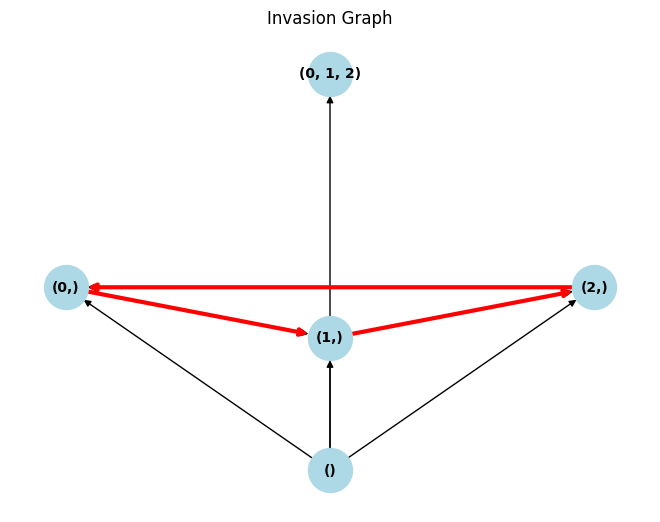

In [ ]:
d = -0.5
A = np.array([
        [ d,  -1, 1],
        [ 1,  d,  -1],
        [ -1,  1,  d]
        ])

b = np.array([1,1,1])
u_S_dict = find_u_S(A, b)
G = create_invasion_graph(A, b)
loops = check_loops(G)
print("Matrix A:")
print(A)
print("Vector b:")
print(b)
print("Loops:")
for loop in loops:
    print(loop)

draw_invasion_graph(G)

# Rock, Scisors, Paper, Lizard, Spock

Matrix A:
[[-0.5 -1.   1.  -1.   1. ]
 [ 1.  -0.5 -1.   1.  -1. ]
 [-1.   1.  -0.5 -1.   1. ]
 [ 1.  -1.   1.  -0.5 -1. ]
 [-1.   1.  -1.   1.  -0.5]]
Vector b:
[1 1 1 1 1]
Loops:
[(0, 1, 4), (0, 1, 2), (1, 2, 3), (2, 3, 4), (0, 3, 4)]
[(2,), (0,), (1,)]
[(2,), (0,), (1,), (4,)]
[(2,), (0,), (3,), (1,)]
[(2,), (0,), (3,), (1,), (4,)]
[(2,), (0,), (3,), (4,)]
[(2,), (3,), (1,)]
[(2,), (3,), (1,), (4,)]
[(2,), (3,), (4,), (0,), (1,)]
[(2,), (3,), (4,)]
[(0,), (1,), (4,)]
[(0,), (3,), (1,), (4,)]
[(0,), (3,), (4,)]


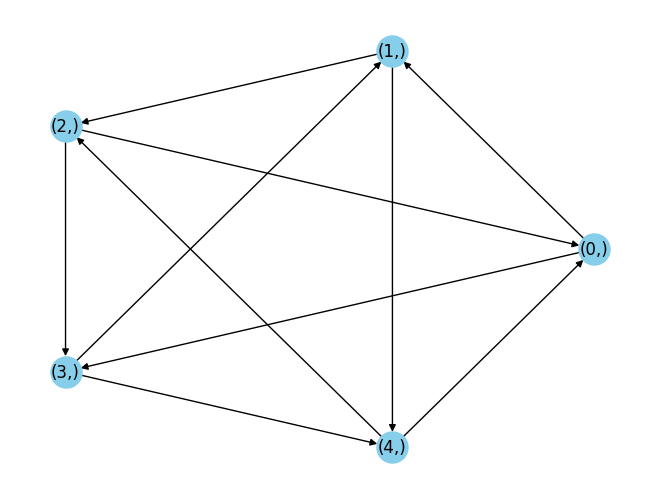

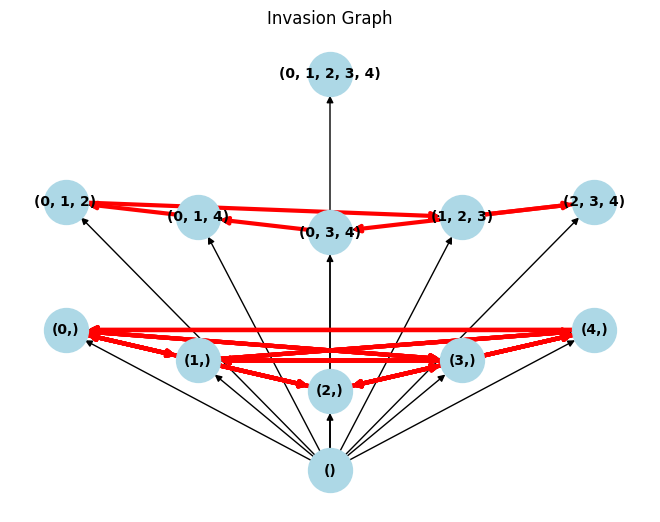

In [ ]:
d = -0.5

A = np.array([
        [ d,  -1, 1,  -1,  1],
        [ 1,  d,  -1,  1,  -1],
        [ -1,  1,  d,  -1,  1],
        [ 1,  -1, 1,  d,  -1],
        [ -1,  1,  -1,  1,  d]
        ])
b = np.array([1,1,1,1,1])
u_S_dict = find_u_S(A, b)
G = create_invasion_graph(A, b)
loops = check_loops(G)
print("Matrix A:")
print(A)
print("Vector b:")
print(b)
print("Loops:")
for loop in loops:
    print(loop)
draw_1_species(G)
draw_invasion_graph(G)

# A complicated story:

Matrix A:
[[-1.61803399  0.         -1.          1.        ]
 [ 1.         -1.61803399  0.         -1.        ]
 [-1.          1.         -1.61803399  0.        ]
 [ 0.         -1.          1.         -1.61803399]]
Vector b:
[1 1 1 1]
Loops:
[(0, 1), (1, 2), (2, 3), (0, 3)]


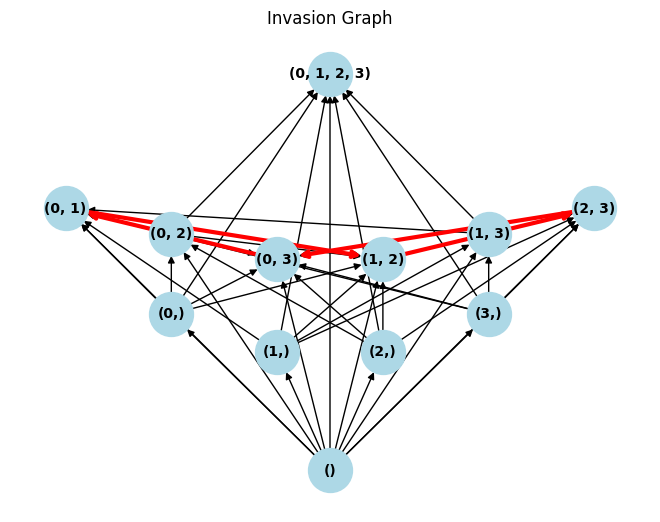

In [ ]:
d = -1.618033988748 # THIS CAN BE AS LOW AS - THE GOLDEN NUMBER LOL. IF LOWER THAN THE NEGATIVE GOLDEN NUMBER, THE LOOP DISSAPEAR!
A = np.array([
        [ d,  0, -1,  1],
        [ 1,  d,  0,  -1],
        [ -1,  1,  d,  0],
        [ 0,  -1,  1,  d]
        ])
b = np.array([1,1,1,1])
u_S_dict = find_u_S(A, b)
G = create_invasion_graph(A, b)
loops = check_loops(G)
print("Matrix A:")
print(A)
print("Vector b:")
print(b)
print("Loops:")
for loop in loops:
    print(loop)
#draw_1_species(G)
draw_invasion_graph(G)